In [1]:
import matplotlib.pyplot as plt
import platform
from matplotlib import font_manager, rc

def set_korean_font():
    plt.rcParams['axes.unicode_minus'] = False  # 마이너스 기호 깨짐 방지
    os_name = platform.system()

    if os_name == 'Linux':
        # 우분투용 폰트 설정
        path = '/usr/share/fonts/truetype/nanum/NanumMyeongjoBold.ttf'
        font_name = font_manager.FontProperties(fname=path, size=12).get_name()
        rc('font', family=font_name)
        print("Linux (Ubuntu) 환경에서 한글 폰트 설정 완료!")
    elif os_name == 'Darwin':
        # macOS용 폰트 설정
        rc('font', family='AppleGothic')
        print("macOS 환경에서 한글 폰트 설정 완료!")
    elif os_name == 'Windows':
        # 윈도우용 폰트 설정
        path = "c:/Windows/Fonts/malgun.ttf"
        font_name = font_manager.FontProperties(fname=path).get_name()
        rc('font', family=font_name)
        print("Windows 환경에서 한글 폰트 설정 완료!")
    else:
        print(f"{os_name}는 지원되지 않는 운영체제입니다.")

# 한글 폰트 설정 실행
set_korean_font()

macOS 환경에서 한글 폰트 설정 완료!


In [2]:
# 필요한 라이브러리 불러오기
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score
from xgboost import XGBClassifier
import matplotlib.pyplot as plt
import seaborn as sns
import re
from sklearn.preprocessing import LabelEncoder


/var/folders/p6/zn1thsjj39x22wz5h1vhtxlh0000gn/T/ipykernel_18054/3611343056.py:2: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [3]:
# 데이터 불러오기
df=pd.read_csv('/Users/jeong-yula/Downloads/open/train.csv')

In [4]:
def year_encoder(x):
    output = x.replace('years', '')
    output = output.replace('year', '')
    output = output.replace('+', '')
    output = output.replace('<', '')
    output = output.replace('Unknown', '0').strip()
    output = int(output)

    return output

df['근로기간'] = df['근로기간'].apply(year_encoder)

In [5]:
drop_index = df[df['주택소유상태'] == 'ANY'].index

df = df.drop(drop_index)

In [6]:
df['근로기간'].unique()

array([ 6, 10,  5,  8,  0,  9,  2,  1,  3,  7,  4])

In [7]:
# 대출기간 전처리
df['대출기간'] = df['대출기간'].str.strip()
df['대출기간'] = df['대출기간'].str.split(' ', expand=True)[0]
df['대출기간'] = df['대출기간'].astype(int)

In [8]:
df['대출기간'].unique()

array([36, 60])

In [9]:
df=df.replace('휴가','휴가_자동차_재생에너지')

In [10]:
df=df.replace('자동차','휴가_자동차_재생에너지')

In [11]:
df=df.replace('재생 에너지','휴가_자동차_재생에너지')

In [12]:
df=df.replace('주택','주거')

In [13]:
df=df.replace('주택 개선','주거')

In [14]:
df=df.replace('이사','주거')

In [15]:
df['대출목적'].unique()

array(['부채 통합', '주거', '주요 구매', '휴가_자동차_재생에너지', '의료', '신용 카드', '소규모 사업',
       '기타'], dtype=object)

In [16]:
pd.set_option('display.max_columns', None) 

In [17]:
df.head()

,ID,대출금액,대출기간,근로기간,주택소유상태,연간소득,부채_대비_소득_비율,총계좌수,대출목적,최근_2년간_연체_횟수,총상환원금,총상환이자,총연체금액,연체계좌수,대출등급
0,TRAIN_00000,12480000,36,6,RENT,72000000,18.90,15,부채 통합,0,0,0.0,0.0,0.0,C
1,TRAIN_00001,14400000,60,10,MORTGAGE,130800000,22.33,21,주거,0,373572,234060.0,0.0,0.0,B
2,TRAIN_00002,12000000,36,5,MORTGAGE,96000000,8.60,14,부채 통합,0,928644,151944.0,0.0,0.0,A
3,TRAIN_00003,14400000,36,8,MORTGAGE,132000000,15.09,15,부채 통합,0,325824,153108.0,0.0,0.0,C
4,TRAIN_00004,18000000,60,0,RENT,71736000,25.39,19,주요 구매,0,228540,148956.0,0.0,0.0,B


In [18]:
# One-Hot Encoding을 사용하여 범주형 변수 인코딩
categorical_features = ['주택소유상태', '대출목적']
df = pd.get_dummies(df, columns=categorical_features)

In [19]:
df.head()

,ID,대출금액,대출기간,근로기간,연간소득,부채_대비_소득_비율,총계좌수,최근_2년간_연체_횟수,총상환원금,총상환이자,총연체금액,연체계좌수,대출등급,주택소유상태_MORTGAGE,주택소유상태_OWN,주택소유상태_RENT,대출목적_기타,대출목적_부채 통합,대출목적_소규모 사업,대출목적_신용 카드,대출목적_의료,대출목적_주거,대출목적_주요 구매,대출목적_휴가_자동차_재생에너지
0,TRAIN_00000,12480000,36,6,72000000,18.90,15,0,0,0.0,0.0,0.0,C,False,False,True,False,True,False,False,False,False,False,False
1,TRAIN_00001,14400000,60,10,130800000,22.33,21,0,373572,234060.0,0.0,0.0,B,True,False,False,False,False,False,False,False,True,False,False
2,TRAIN_00002,12000000,36,5,96000000,8.60,14,0,928644,151944.0,0.0,0.0,A,True,False,False,False,True,False,False,False,False,False,False
3,TRAIN_00003,14400000,36,8,132000000,15.09,15,0,325824,153108.0,0.0,0.0,C,True,False,False,False,True,False,False,False,False,False,False
4,TRAIN_00004,18000000,60,0,71736000,25.39,19,0,228540,148956.0,0.0,0.0,B,False,False,True,False,False,False,False,False,False,True,False


In [21]:

numeric_cols = ['연간소득', '총계좌수', '최근_2년간_연체_횟수', '총상환원금', '총상환이자', '총연체금액','부채_대비_소득_비율']

# 표준편차 사용하여 이상치 제거
def remove_outliers(df, col, threshold=3):
    mean = np.mean(df[col])
    std_dev = np.std(df[col])
    lower_bound = mean - threshold * std_dev
    upper_bound = mean + threshold * std_dev
    df= df[(df[col] >= lower_bound) & (df[col] <= upper_bound)]
    return df

# 이상치 제거 후 데이터프레임 생성
df = df.copy()  # 복사본 생성

for col in numeric_cols:
    df = remove_outliers(df, col, threshold=3)

In [23]:
log_processing = ['최근_2년간_연체_횟수', '총연체금액']

for col in log_processing:
    df[col] = np.log1p(df[col])

In [24]:
from sklearn.model_selection import train_test_split

X = df.drop(['ID', '대출등급'], axis=1)
y = df[['대출등급']]

print(X.shape, y.shape)

(90618, 22) (90618, 1)


In [25]:
def numeric_scaler(X):
    
    sc_col = ['최근_2년간_연체_횟수', '총연체금액', '연체계좌수']
    mm_col = ['대출금액', '연간소득', '부채_대비_소득_비율', '총계좌수', '총상환원금', '총상환이자', '근로기간']
    
    from sklearn.preprocessing import StandardScaler, MinMaxScaler
    
    sc = StandardScaler()
    mm = MinMaxScaler()
    
    X[sc_col] = sc.fit_transform(X[sc_col])
    X[mm_col] = mm.fit_transform(X[mm_col])
    
    return X

X = numeric_scaler(X)

In [34]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
le.fit(y['대출등급'])


y['대출등급'] = le.transform(y['대출등급'])

/var/folders/p6/zn1thsjj39x22wz5h1vhtxlh0000gn/T/ipykernel_18054/2534684636.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y['대출등급'] = le.transform(y['대출등급'])


파생변수

In [33]:
X.columns

Index(['대출금액', '대출기간', '근로기간', '연간소득', '부채_대비_소득_비율', '총계좌수', '최근_2년간_연체_횟수',
       '총상환원금', '총상환이자', '총연체금액', '연체계좌수', '주택소유상태_MORTGAGE', '주택소유상태_OWN',
       '주택소유상태_RENT', '대출목적_기타', '대출목적_부채 통합', '대출목적_소규모 사업', '대출목적_신용 카드',
       '대출목적_의료', '대출목적_주거', '대출목적_주요 구매', '대출목적_휴가_자동차_재생에너지'],
      dtype='object')

In [38]:
X['dv_category'] = ( X['주택소유상태_MORTGAGE'] + X['대출목적_부채 통합']) / 4
X['dv_ratio'] = X['총상환원금'] + 1 / X['대출금액'] + 1
X['dv_short_ability'] = (X['연간소득'] / 12) - (X['대출금액'] / 36)
X['dv_left_debt'] = X['대출금액'] - X['총상환원금'] - X['총상환이자']

In [39]:
X = X.replace([np.nan, np.inf, -np.inf], 1)

In [40]:
X.columns

Index(['대출금액', '대출기간', '근로기간', '연간소득', '부채_대비_소득_비율', '총계좌수', '최근_2년간_연체_횟수',
       '총상환원금', '총상환이자', '총연체금액', '연체계좌수', '주택소유상태_MORTGAGE', '주택소유상태_OWN',
       '주택소유상태_RENT', '대출목적_기타', '대출목적_부채 통합', '대출목적_소규모 사업', '대출목적_신용 카드',
       '대출목적_의료', '대출목적_주거', '대출목적_주요 구매', '대출목적_휴가_자동차_재생에너지', 'dv_category',
       'dv_ratio', 'dv_short_ability', 'dv_left_debt'],
      dtype='object')

오버샘플링

In [30]:
from imblearn.over_sampling import SMOTE
sm = SMOTE(random_state=42)

X, y = sm.fit_resample(X, y)

In [82]:

# # 훈련 데이터와 테스트 데이터 분할
# X = df.drop(['ID', '대출등급'], axis=1)
# y = df['대출등급']
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [89]:
# # 모델링 (XGBoost)
# model = XGBClassifier(use_label_encoder=False, eval_metric='mlogloss')
# model.fit(X_train, y_train)

# # 모델 평가
# y_pred = model.predict(X_test)
# accuracy = accuracy_score(y_test, y_pred)
# conf_matrix = confusion_matrix(y_test, y_pred)
# precision = precision_score(y_test, y_pred, average='macro')
# recall = recall_score(y_test, y_pred, average='macro')
# f1 = f1_score(y_test, y_pred, average='macro')

# print(f"정확도: {accuracy}")
# print(f"혼동 행렬:\n{conf_matrix}")
# print(f"정밀도: {precision}")
# print(f"재현율: {recall}")
# print(f"F1 점수: {f1}")

정확도: 0.8528470536305451
혼동 행렬:
[[  27   24    9    0    4    0    0]
 [   5  196   55    6   12    5    0]
 [   1   26  894  292   57   13    0]
 [   0    6  151 1950  251   70    9]
 [   0    1   24  210 4711  374   31]
 [   0    0    2   16  366 4824  295]
 [   0    0    0    1   18  333 2855]]
정밀도: 0.827325432294779
재현율: 0.7526573579521435
F1 점수: 0.7802692102851593


In [36]:
from sklearn.model_selection import train_test_split
X = df.drop(['ID', '대출등급'], axis=1)
y = df[['대출등급']]

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

In [37]:
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, f1_score
    
xgb = XGBClassifier(random_state=42)
xgb.fit(X_train, y_train)
    
y_pred_train = xgb.predict(X_train)
y_pred_val = xgb.predict(X_val)
    
result_xgb = pd.DataFrame(data={'acc' : [accuracy_score(y_train, y_pred_train), accuracy_score(y_val, y_pred_val)],
                                'f1_score' : [f1_score(y_train, y_pred_train, average='macro'), f1_score(y_val, y_pred_val, average='macro')]},
                          index=['train','test'])
    
display(result_xgb.round(2))

,acc,f1_score
train,0.91,0.93
test,0.85,0.78


In [40]:
# 파생변수 추가 후 
xgb = XGBClassifier(random_state=42)
xgb.fit(X_train, y_train)
    
y_pred_train = xgb.predict(X_train)
y_pred_val = xgb.predict(X_val)
    
result_xgb = pd.DataFrame(data={'acc' : [accuracy_score(y_train, y_pred_train), accuracy_score(y_val, y_pred_val)],
                                'f1_score' : [f1_score(y_train, y_pred_train, average='macro'), f1_score(y_val, y_pred_val, average='macro')]},
                          index=['train','test'])
    
display(result_xgb.round(2))

,acc,f1_score
train,0.91,0.93
test,0.85,0.78


In [42]:
from sklearn.metrics import confusion_matrix
confusion = confusion_matrix(y_val, y_pred_val)
confusion

array([[2865,  339,   21,    1,    0,    0,    0],
       [ 315, 4812,  398,    7,    3,    0,    0],
       [  42,  392, 4620,  205,   13,    0,    0],
       [   6,   68,  249, 1953,  174,    5,    2],
       [   3,   24,   56,  222,  951,   21,    1],
       [   0,    3,   10,    8,   63,  204,   11],
       [   0,    0,    4,    3,    2,   22,   26]])

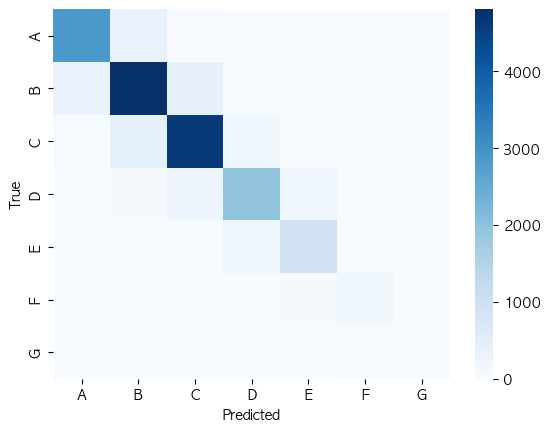

In [43]:
labels = ['A', 'B', 'C', 'D', 'E', 'F', 'G']
sns.heatmap(confusion, cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

In [36]:
!pip install xgboost
!pip install lightgbm

Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 23.3.2 -> 24.0
[notice] To update, run: /Library/Developer/CommandLineTools/usr/bin/python3 -m pip install --upgrade pip
Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 23.3.2 -> 24.0
[notice] To update, run: /Library/Developer/CommandLineTools/usr/bin/python3 -m pip install --upgrade pip


In [41]:
# lightgbm을 구현하여 shap value를 예측할 것
# ligthgbm 구현

# library
import lightgbm as lgb  # 없을 경우 cmd/anaconda prompt에서 install
from math import sqrt
from sklearn.metrics import mean_squared_error

# lightgbm model
lgb_dtrain = lgb.Dataset(data = X_train, label = y_train) # LightGBM 모델에 맞게 변환
lgb_param = {'max_depth': 10,
            'learning_rate': 0.01, # Step Size
            'n_estimators': 1000, # Number of trees
            'objective': 'regression'} # 목적 함수 (L2 Loss)
lgb_model = lgb.train(params = lgb_param, train_set = lgb_dtrain) # 학습 진행
lgb_model_predict = lgb_model.predict(X_val) # test data 예측
print("RMSE: {}".format(sqrt(mean_squared_error(lgb_model_predict, y_val)))) # RMSE

/Users/jeong-yula/Library/Python/3.9/lib/python/site-packages/lightgbm/engine.py:172: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.007259 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1898
[LightGBM] [Info] Number of data points in the train set: 154974, number of used features: 19
[LightGBM] [Info] Start training from score 2.999981
RMSE: 0.4515150244024678


In [42]:
!pip install shap (에러 발생시, skimage version 확인 (0.14.2 이상 권장))
# import skimage -> skimage.__version__ (skimage version 확인)
# skimage version upgrade -> !pip install --upgrade scikit-image

zsh:1: no matches found: (에러 발생시, skimage version 확인 (0.14.2 이상 권장))


In [ ]:
pip install scikit-image

In [44]:
import skimage

In [45]:
skimage.__version__

'0.22.0'

In [ ]:
!pip install --upgrade scikit-image

In [ ]:
pip install shap

In [50]:
# shap value 
import shap
explainer = shap.TreeExplainer(lgb_model) # Tree model Shap Value 확인 객체 지정
shap_values = explainer.shap_values(X_test) # Shap Values 계산

In [ ]:
!pip install ipywidgets

In [51]:
shap.initjs() # javascript 초기화 (graph 초기화)
shap.force_plot(explainer.expected_value, shap_values[1,:], X_test.iloc[1,:])

In [47]:
# # 전체 검증 데이터 셋에 대해서 적용
# shap.force_plot(explainer.expected_value, shap_values, test_x) 

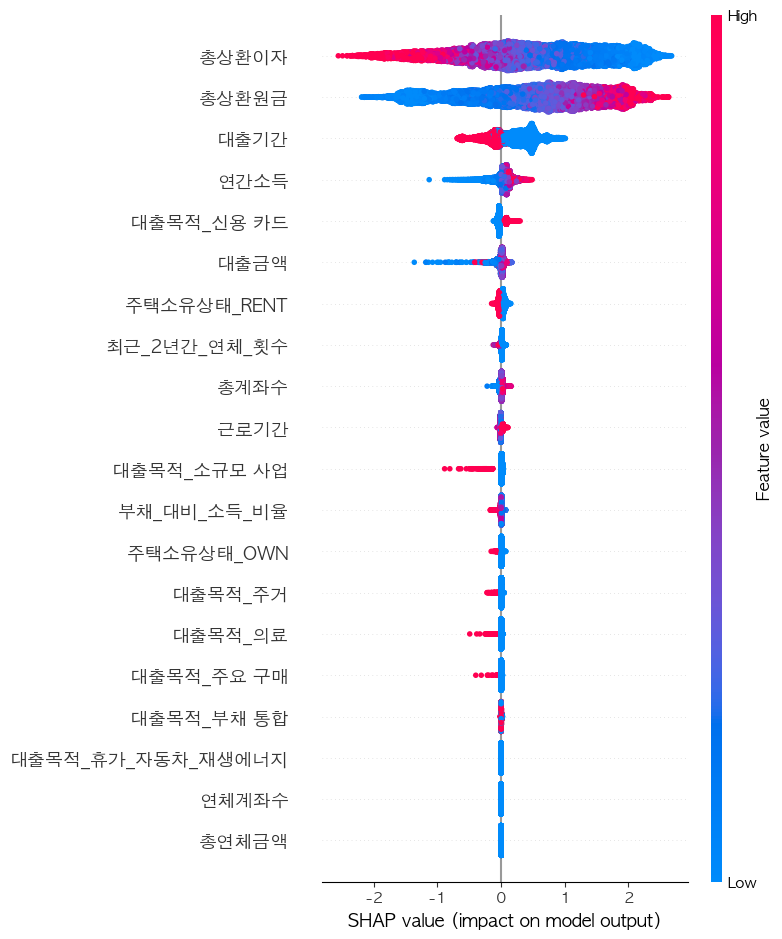

In [53]:
# summary
shap.summary_plot(shap_values, X_test)